Loading YOLOv8-seg model...
Processing image...
Performing segmentation...
Creating semantic mask...
Analyzing segments...
Creating visualizations...
Displaying results...


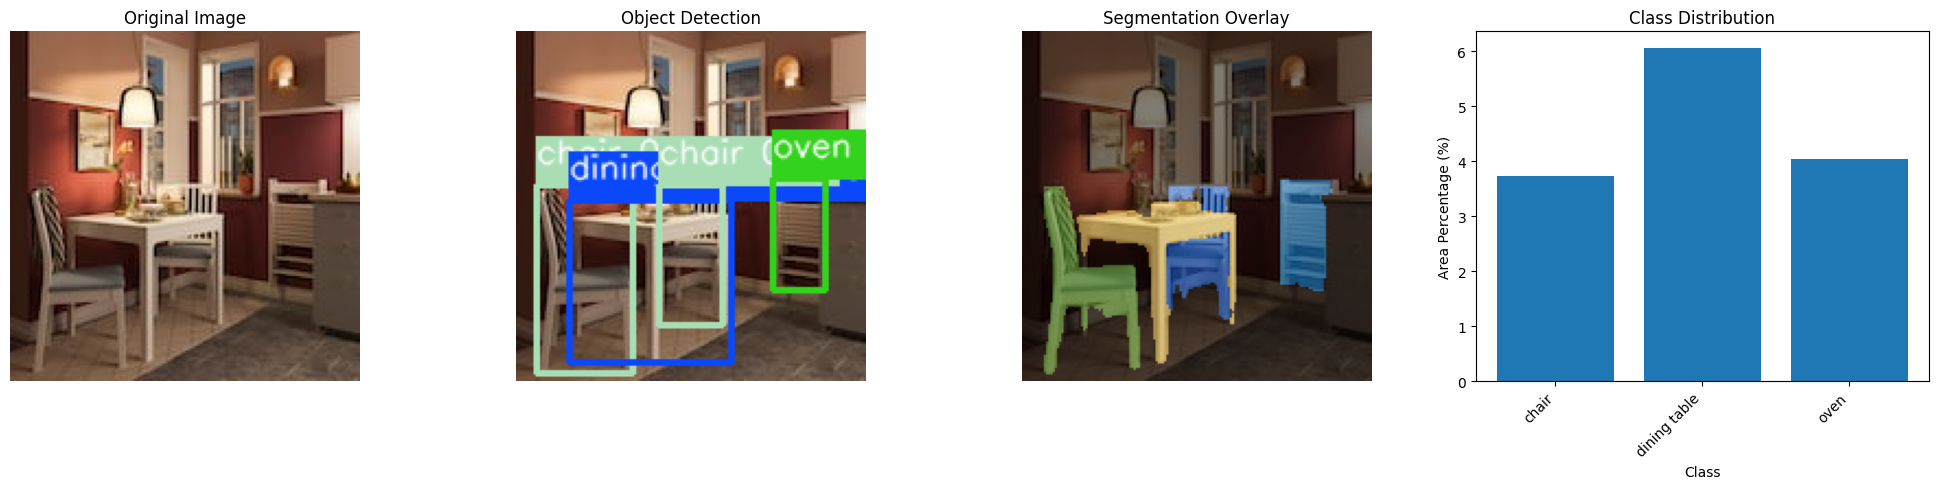

Saving results...
chair: 3.73% of image area
dining table: 6.06% of image area
oven: 4.04% of image area

Extracting and saving bbox images...
Saved bbox image: C:\Users\admin\ekedalen-chair-white-ramna-light-grey__0719156_pe731888_s5_bbox_chair_0_20241231_121444.png
Saved bbox image: C:\Users\admin\ekedalen-chair-white-ramna-light-grey__0719156_pe731888_s5_bbox_dining table_1_20241231_121444.png
Saved bbox image: C:\Users\admin\ekedalen-chair-white-ramna-light-grey__0719156_pe731888_s5_bbox_chair_2_20241231_121444.png
Saved bbox image: C:\Users\admin\ekedalen-chair-white-ramna-light-grey__0719156_pe731888_s5_bbox_oven_3_20241231_121444.png
Processing complete!


In [14]:
from ultralytics import YOLO
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime

def load_model():
    """
    Load YOLOv8 segmentation model
    Returns:
        model: Pre-trained YOLOv8 model
    """
    model = YOLO('yolov8x-seg.pt')
    return model

def process_image(image_path):
    """
    Load and process image for segmentation
    Args:
        image_path: Path to input image
    Returns:
        image: Original image
        pil_image: PIL Image for visualization
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image)
    return image, pil_image

def segment_image(model, image):
    """
    Perform semantic segmentation on the input image
    Args:
        model: YOLOv8 model
        image: Input image
    Returns:
        results: Segmentation results
    """
    results = model.predict(
        source=image,
        conf=0.25,  # Confidence threshold
        iou=0.45,   # NMS IoU threshold
        verbose=False
    )
    return results[0]

def create_semantic_mask(results):
    """
    Create a semantic segmentation mask
    Args:
        results: YOLOv8 prediction results
    Returns:
        semantic_mask: Combined semantic mask
        class_map: Dictionary mapping pixel values to class IDs
    """
    height, width = results.orig_shape[:2]
    semantic_mask = np.zeros((height, width), dtype=np.uint8)
    masks = results.masks
    cls = results.boxes.cls.cpu().numpy()
    
    if masks is None:
        return semantic_mask, {}
        
    class_map = {}
    for i, (mask, class_id) in enumerate(zip(masks.data, cls)):
        mask = mask.cpu().numpy()
        mask = cv2.resize(mask.astype(float), (width, height)) > 0.5
        class_id = int(class_id)
        mask_value = i + 1  # Use index+1 as mask value to avoid 0
        semantic_mask[mask] = mask_value
        class_map[mask_value] = class_id
        
    return semantic_mask, class_map

def analyze_segments(semantic_mask, class_map, class_names):
    """
    Calculate class percentages from semantic mask
    Args:
        semantic_mask: Semantic segmentation mask
        class_map: Dictionary mapping pixel values to class IDs
        class_names: Dictionary of class names
    Returns:
        class_percentages: Dictionary of class percentages
    """
    total_pixels = semantic_mask.shape[0] * semantic_mask.shape[1]
    class_percentages = {}
    
    # Count pixels for each class
    for mask_value, class_id in class_map.items():
        pixel_count = np.sum(semantic_mask == mask_value)
        percentage = (pixel_count / total_pixels) * 100
        class_percentages[class_names[class_id]] = round(percentage, 2)
    
    return class_percentages

def create_overlay_mask(image, semantic_mask, class_map, alpha=0.5):
    """
    Create colored overlay mask on original image
    Args:
        image: Original image
        semantic_mask: Semantic segmentation mask
        class_map: Dictionary mapping pixel values to class IDs
        alpha: Transparency value (0-1)
    Returns:
        overlay: Image with semi-transparent colored overlay
    """
    height, width = semantic_mask.shape
    overlay = image.copy()
    
    # Create random colors for each class
    np.random.seed(42)  # For consistent colors
    colors = np.random.randint(0, 255, (len(class_map) + 1, 3), dtype=np.uint8)
    
    # Create colored mask
    colored_mask = np.zeros_like(image)
    for mask_value in class_map.keys():
        colored_mask[semantic_mask == mask_value] = colors[mask_value]
    
    # Apply overlay with alpha blending
    cv2.addWeighted(colored_mask, alpha, image, 1 - alpha, 0, overlay)
    
    return overlay

def draw_boxes(image, results):
    """
    Draw bounding boxes and labels on the image
    Args:
        image: Original image
        results: YOLOv8 prediction results
    Returns:
        image_with_boxes: Image with drawn boxes and labels
    """
    image_with_boxes = image.copy()
    
    if results.boxes is None or len(results.boxes) == 0:
        return image_with_boxes
        
    # Get bounding boxes, class IDs, and confidence scores
    boxes = results.boxes.xyxy.cpu().numpy()
    class_ids = results.boxes.cls.cpu().numpy()
    scores = results.boxes.conf.cpu().numpy()
    
    # Define colors for different classes
    np.random.seed(42)  # For consistent colors
    colors = np.random.randint(0, 255, size=(len(results.names), 3), dtype=np.uint8)
    
    # Draw each box
    for box, class_id, score in zip(boxes, class_ids, scores):
        x1, y1, x2, y2 = map(int, box[:4])
        color = tuple(map(int, colors[int(class_id)]))
        
        # Draw box
        cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), color, 2)
        
        # Create label with class name and confidence
        class_name = results.names[int(class_id)]
        label = f'{class_name} {score:.2f}'
        
        # Get label size and background size
        (label_width, label_height), baseline = cv2.getTextSize(
            label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1
        )
        
        # Draw label background
        cv2.rectangle(
            image_with_boxes, 
            (x1, y1 - label_height - baseline - 5),
            (x1 + label_width, y1),
            color, 
            cv2.FILLED
        )
        
        # Draw label text
        cv2.putText(
            image_with_boxes,
            label,
            (x1, y1 - baseline - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 255, 255),
            1,
            cv2.LINE_AA
        )
    
    return image_with_boxes

def save_bbox_images(image, results, base_path):
    """
    Extract and save individual objects using bounding boxes
    Args:
        image: Original image
        results: YOLOv8 prediction results
        base_path: Base path for saving files
    """
    if results.boxes is None or len(results.boxes) == 0:
        print("No objects detected for bbox extraction")
        return
        
    # Get bounding boxes and class IDs
    boxes = results.boxes.xyxy.cpu().numpy()  # x1, y1, x2, y2
    class_ids = results.boxes.cls.cpu().numpy()
    
    # Extract and save each detected object
    for i, (box, class_id) in enumerate(zip(boxes, class_ids)):
        x1, y1, x2, y2 = map(int, box[:4])
        class_name = results.names[int(class_id)]
        
        # Extract the region
        object_img = image[y1:y2, x1:x2].copy()
        
        # Save the extracted region
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'{base_path}_bbox_{class_name}_{i}_{timestamp}.png'
        
        # Convert to PIL Image and save
        object_img_pil = Image.fromarray(object_img)
        object_img_pil.save(filename)
        print(f"Saved bbox image: {filename}")

def visualize_results(image, overlay_mask, image_with_boxes, class_percentages):
    """
    Visualize detection results with four subplots
    Args:
        image: Original image
        overlay_mask: Image with colored overlay
        image_with_boxes: Image with drawn bounding boxes
        class_percentages: Dictionary of class percentages
    """
    plt.figure(figsize=(20, 5))
    
    # Original image
    plt.subplot(141)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis('off')
    
    # Bounding boxes
    plt.subplot(142)
    plt.title("Object Detection")
    plt.imshow(image_with_boxes)
    plt.axis('off')
    
    # Overlay segmentation
    plt.subplot(143)
    plt.title("Segmentation Overlay")
    plt.imshow(overlay_mask)
    plt.axis('off')
    
    # Class distribution
    plt.subplot(144)
    plt.title("Class Distribution")
    if class_percentages:
        classes = list(class_percentages.keys())
        percentages = list(class_percentages.values())
        plt.bar(range(len(classes)), percentages)
        plt.xticks(range(len(classes)), classes, rotation=45, ha='right')
        plt.xlabel("Class")
        plt.ylabel("Area Percentage (%)")
    else:
        plt.text(0.5, 0.5, "No objects detected", 
                horizontalalignment='center',
                verticalalignment='center')
    
    plt.tight_layout()
    plt.show()

def save_all_results(class_percentages, overlay_mask, results, image, image_with_boxes, base_path):
    """
    Save all analysis results including bbox images
    Args:
        class_percentages: Dictionary of class percentages
        overlay_mask: Image with segmentation overlay
        results: YOLOv8 prediction results
        image: Original image
        image_with_boxes: Image with drawn bounding boxes
        base_path: Base path for saving files
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save analysis results to text file and print to console
    with open(f'{base_path}_analysis_{timestamp}.txt', 'w') as f:
        f.write("Semantic Segmentation Analysis Results\n")
        f.write("====================================\n")
        if class_percentages:
            for class_name, percentage in class_percentages.items():
                result = f"{class_name}: {percentage}% of image area"
                f.write(result + "\n")
                print(result)
        else:
            f.write("No objects detected in the image\n")
            print("No objects detected in the image")
    
    # Save segmentation overlay
    Image.fromarray(overlay_mask).save(f'{base_path}_segmentation_{timestamp}.png')
    
    # Save image with bounding boxes
    Image.fromarray(image_with_boxes).save(f'{base_path}_boxes_{timestamp}.png')
    
    # Save individual bbox images
    print("\nExtracting and saving bbox images...")
    save_bbox_images(image, results, base_path)

def main(image_path):
    """
    Main function to perform semantic segmentation and analysis
    Args:
        image_path: Path to input image
    """
    print("Loading YOLOv8-seg model...")
    model = load_model()
    
    print("Processing image...")
    image, _ = process_image(image_path)
    
    print("Performing segmentation...")
    results = segment_image(model, image)
    
    print("Creating semantic mask...")
    semantic_mask, class_map = create_semantic_mask(results)
    
    print("Analyzing segments...")
    class_percentages = analyze_segments(semantic_mask, class_map, results.names)
    
    print("Creating visualizations...")
    overlay_mask = create_overlay_mask(image, semantic_mask, class_map, alpha=0.5)
    image_with_boxes = draw_boxes(image, results)
    
    print("Displaying results...")
    visualize_results(image, overlay_mask, image_with_boxes, class_percentages)
    
    print("Saving results...")
    base_path = image_path.rsplit('.', 1)[0]
    save_all_results(class_percentages, overlay_mask, results, image, image_with_boxes, base_path)
    
    print("Processing complete!")

if __name__ == "__main__":
    # Replace with your image path
    image_path = r"C:\Users\admin\ekedalen-chair-white-ramna-light-grey__0719156_pe731888_s5.jpg"
    main(image_path)